# Tool Calling using Llama 3.2 🔧

In this notebook, we'll explore the **tool-calling capabilities** of the **Llama 3.2 models**. Our goal is to show how the tool system works under the hood, so you have a clear understanding of its capabilities. For deployment options, you may want to consider [llama-stack-apps](https://github.com/meta-llama/llama-stack-apps) and [llama-stack](https://github.com/meta-llama/llama-stack). For more details about the model, you may also consider reviewing the official documentation for [tool calling with Llama 3.2](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_2#-tool-calling-(1b/3b)-).

The **Llama 3.2 family** offers a diverse range of models tailored for various use cases. To explore the full collection, visit the [Llama 3.2 family collection](https://huggingface.co/collections/meta-llama/llama-32-66f448ffc8c32f949b04c8cf).

Below is a diagram illustrating a **tool-calling pipeline**. We will recreate and implement this pipeline step-by-step in this notebook.

Let's get started! 🚀





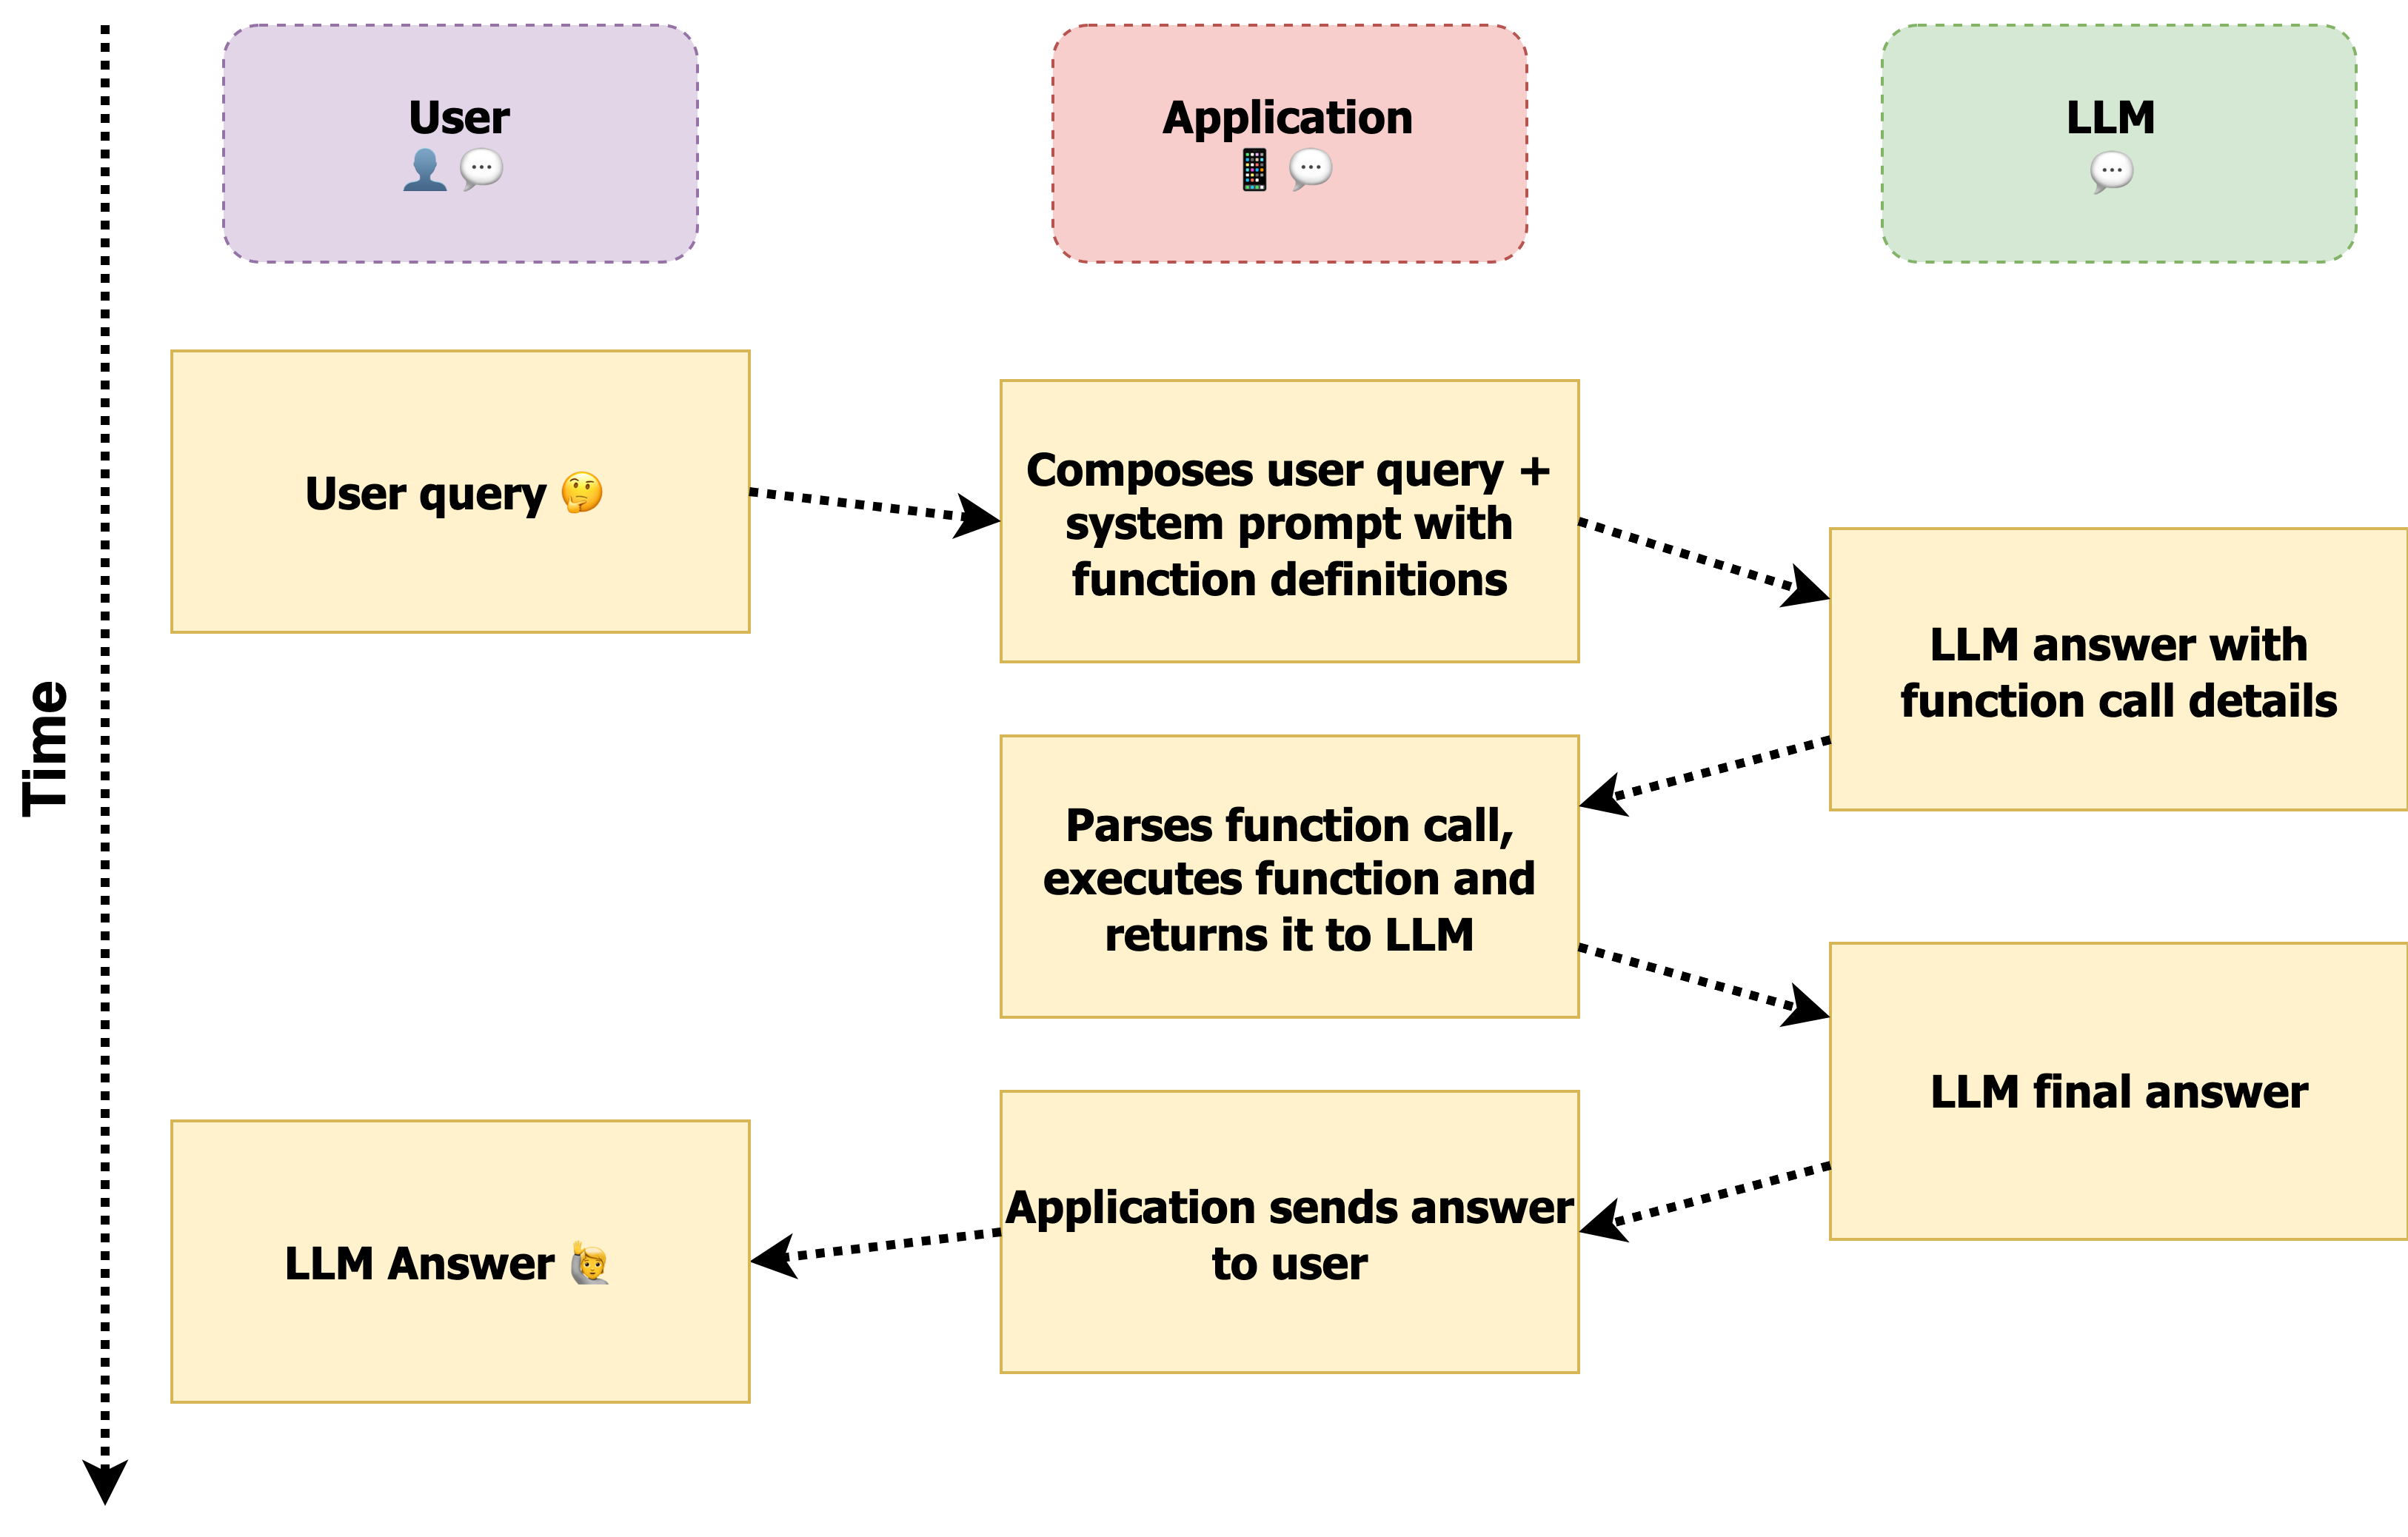

## 1. Setup and Imports 🛠️  

Before we dive in, let's start by installing the necessary dependencies to ensure our environment is ready for the tool-calling examples.


In [ ]:
!pip install -q llama-stack

We'll login to **Hugging Face** since these models are gated. If you haven't requested access yet, make sure to do so and confirm that it has been granted.  

For more details, refer to the [Model Card](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct).

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

For our experiments, we'll use the base model **`meta-llama/Llama-3.2-3B-Instruct`** and demonstrate how to complete tool invocations.   


In [ ]:
checkpoint = "meta-llama/Llama-3.2-3B-Instruct"
model = AutoModelForCausalLM.from_pretrained(checkpoint, torch_dtype=torch.bfloat16, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

model = model.eval()

We'll define a `generate` function to streamline our workflow. This function will handle model calls using a given prompt and return the model's response. We'll use it throughout the notebook for consistency and ease of use.  


In [ ]:
def generate(prompt, model, tokenizer):
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=150, do_sample=True)

    result = outputs[0][inputs["input_ids"].shape[-1]:]
    return tokenizer.decode(result, skip_special_tokens=False)

## 2. Custom Tool 🔧  

For our first experiment, we'll create a custom tool that performs a simple task: adding two integer numbers.  

We'll explore two possible ways of generating this behavior:

1. Using a traditional string implementation
2. Using a Chat Template


### 2.1 Using a Traditional String Implementation

The addition tool can be represented as the following Python function:  


In [ ]:
def add_two_integers(x: int, y: int):
    """
    Adds two integer numerals

    Args:
        x: An integer
        y: An integer
    """
    return x + y

Below, we define the `system_prompt`.  

The system prompt for tool calling is made up of two key components:  
1. **`prior_system_instruction`**: This is the default foundational prompt. It describes the tool-calling functionality and outlines its workflow. If you examine it closely, you'll notice how it provides a clear explanation of how tools are integrated and utilized.  
2. **Custom tools in JSON format**: This is a list of tools the model can access and call (e.g., the `add_two_integers` function in our example).  

These two parts are combined to form the complete `system_prompt`.  


In [ ]:
prior_system_instruction = """\
<|start_header_id|>system<|end_header_id|>

You are an expert in composing functions. You are given a question and a set of possible functions.
Based on the question, you will need to make one or more function/tool calls to achieve the purpose.
If none of the function can be used, point it out. If the given question lacks the parameters required by the function,
also point it out. You should only return the function call in tools call sections.

If you decide to invoke any of the function(s), you MUST put it in the format of [func_name1(params_name1=params_value1, params_name2=params_value2...), func_name2(params)]
You SHOULD NOT include any other text in the response.

Here is a list of functions in JSON format that you can invoke."""

custom_tool = """\
[
    {
        "name": "add_two_integers",
        "description": "Adds two integer numerals",
        "parameters": {
            "type": "dict",
            "required": ["x", "y"],
            "properties": {
                "x": {
                    "type": "integer",
                    "description": "An integer"
                },
                "y": {
                    "type": "integer",
                    "description": "An integer"
                },
            }
        }
    }
]"""


system_prompt = f"{prior_system_instruction}{custom_tool}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n"

Next, we'll define the `user_prompt`, which simulates the user's input during their turn in the interaction. This prompt represents what the user would say or request, guiding the model to generate appropriate responses or perform specific actions using the defined tools.  


In [ ]:
user_prompt = "What is the result of 12322 added to 1242453"

prompt = f"{system_prompt}{user_prompt}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

Now, let's take a look at how the final prompt is structured, and generate the model's response based on it.  


In [ ]:
print(prompt)

<|start_header_id|>system<|end_header_id|>

You are an expert in composing functions. You are given a question and a set of possible functions.
Based on the question, you will need to make one or more function/tool calls to achieve the purpose.
If none of the function can be used, point it out. If the given question lacks the parameters required by the function,
also point it out. You should only return the function call in tools call sections.

If you decide to invoke any of the function(s), you MUST put it in the format of [func_name1(params_name1=params_value1, params_name2=params_value2...), func_name2(params)]
You SHOULD NOT include any other text in the response.

Here is a list of functions in JSON format that you can invoke.[
    {
        "name": "add_two_integers",
        "description": "Adds two integer numerals",
        "parameters": {
            "type": "dict",
            "required": ["x", "y"],
            "properties": {
                "x": {
                    "ty

As you can see, the different special tokens (`<|eot_id|>`, `<|start_header_id|>`, etc.) indicate the turns in the conversation and help manage the workflow.

Now, let's use this prompt as input to the model and check if it correctly understands that the tool needs to be called.  


In [ ]:
model_tool_call_response = generate(prompt, model, tokenizer)
print(model_tool_call_response)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[add_two_integers(x=12322, y=1242453)]<|eot_id|>


As we can see, the model correctly understood the task and suggested a call to the custom tool, following the format we previously defined.  

However, it's important to note that this is not the final response from the model. Tool calling occurs automatically, without any direct intervention from the user.  

In a chat service, for example, we'd display a progress indicator and possibly a message indicating that additional information is being retrieved (e.g., browsing the web). The user would not see the raw response from `add_two_integers` directly.  

What follows is the code required to complete the query and provide the final response. If you're interested in the underlying architecture, there's a helpful diagram illustrating it [here](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_1/#-tool-calling-(8b/70b/405b)-).  





#### Call to the Tool  

To complete the query, we'll invoke the tool to perform the operation and add the result back to the prompt. This step involves calling our previously defined function to execute the addition.  

It's important to note that this process is managed outside of the model, handled by a **code executor**. The model generates the method signature, but we need to execute the actual call externally to complete the operation.  



In [ ]:
tool_call_response = str(add_two_integers(x=12322, y=1242453))
print(tool_call_response)

1254775


#### Add Everything to the Main Prompt  

Now that we have the result, we can combine all the components into the complete prompt for the final output. This includes:  
- The **initial system prompt**  
- The **user input**  
- The **tool's response**  

These elements together form the full interaction for the model.  

It's worth noting that the `<|python_tag|>` token is simply a convention chosen to indicate that a tool call invocation is required. It doesn't strictly mean the tool must be executed in Python. We're free to use any mechanism to invoke the tool, as long as it processes the function and returns the response in the format expected by the model.  

Additionally, we include the `<|start_header_id|>ipython<|end_header_id|>` token just before the tool call response to signal its context appropriately.  




In [ ]:
prompt = f"{prompt}<|python_tag|>{model_tool_call_response}<|start_header_id|>ipython<|end_header_id|>\n\n"

prompt = prompt + f'"{tool_call_response}"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'
print(prompt)

<|start_header_id|>system<|end_header_id|>

You are an expert in composing functions. You are given a question and a set of possible functions.
Based on the question, you will need to make one or more function/tool calls to achieve the purpose.
If none of the function can be used, point it out. If the given question lacks the parameters required by the function,
also point it out. You should only return the function call in tools call sections.

If you decide to invoke any of the function(s), you MUST put it in the format of [func_name1(params_name1=params_value1, params_name2=params_value2...), func_name2(params)]
You SHOULD NOT include any other text in the response.

Here is a list of functions in JSON format that you can invoke.[
    {
        "name": "add_two_integers",
        "description": "Adds two integer numerals",
        "parameters": {
            "type": "dict",
            "required": ["x", "y"],
            "properties": {
                "x": {
                    "ty

Finally, we'll call the model again using the complete prompt to see how it performs! This step combines all the elements into a single input, allowing the model to generate its final output.  

The results, excluding the `<|eot_id|>` token, would represent the actual response provided to the user in a real application scenario. This ensures a seamless experience where the tool's execution is invisible to the end user, and only the refined answer is displayed.  


In [ ]:
print(generate(prompt, model, tokenizer))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


The result of adding 12322 to 1242453 is 1254775.<|eot_id|>


In addition to this format, where we define the functions in the `system_prompt`, you can also include the function definitions and query in the `user_prompt` directly. You can find more information about how to do it [here](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_2/#-function-definitions-and-query-in-the-user-prompt-).

### 2.2 Using a Chat Template  

The traditional string implementation, while functional, is prone to errors due to the need to manually manage tokens, line breaks, and formatting. To streamline this process, we can use a **chat template**. This approach seamlessly integrates interactions, making it easier to build applications without worrying about the underlying tokenization structure.  

For more details about chat templates, check out the [official documentation](https://huggingface.co/docs/transformers/main/chat_templating).  

In the following example, we'll demonstrate how to replicate the same behavior as before using the `chat_template` functionality. The code cell below defines the chat structure required to interact with the model, implemented as a Jinja template. While it might appear complex at first glance, the end result matches what we achieved with the traditional string-based approach.  

🧑‍🏫️ Let's dive in and see it in action!  

---

**⚠️ Note:**  
During our experiments with the Llama 3.2 model for tool calling, we observed that the `chat_template` is highly sensitive. Despite following the structure proposed in the [official documentation](https://github.com/meta-llama/llama-models/blob/main/models/llama3_2/text_prompt_format.md#zero-shot-function-calling-e2e-format), we experienced inconsistencies in the output.  

- **Observation:** Sometimes, the model generates the correct output; other times, it fails to do so.  
- The following `chat_template` represents the most reliable examples we were able to produce during our experiments.  

---

Let's see how it works! 🚀



In [ ]:
chat_template="""\
{{- bos_token }}
{%- if custom_tools is defined %}
    {%- set tools = custom_tools %}
{%- endif %}
{%- if not tools_in_user_message is defined %}
    {%- set tools_in_user_message = false %}
{%- endif %}
{%- if not date_string is defined %}
    {%- if strftime_now is defined %}
        {%- set date_string = strftime_now("%d %b %Y") %}
    {%- else %}
        {%- set date_string = "24 September 2024" %}
    {%- endif %}
{%- endif %}
{%- if not tools is defined %}
    {%- set tools = none %}
{%- endif %}

{#- This block extracts the system message, so we can slot it into the right place. #}
{%- if messages[0]['role'] == 'system' %}
    {%- set system_message = messages[0]['content']|trim %}
    {%- set messages = messages[1:] %}
{%- else %}
    {%- set system_message = "" %}
{%- endif %}

{#- System message + environment setup (modified for 3.2) #}
{{- "<|start_header_id|>system<|end_header_id|>\n\n" }}
{%- if tools is not none %}
    {{- "You are an expert in composing functions. You are given a question and a set of possible functions.\n" }}
    {{- "Based on the question, you will need to make one or more function/tool calls to achieve the purpose.\n" }}
    {{- "If none of the function can be used, point it out. If the given question lacks the parameters required by the function,\n" }}
    {{- "also point it out. You should only return the function call in tools call sections.\n\n" }}
    {{- "If you decide to invoke any of the function(s), you MUST put it in the format of [func_name1(params_name1=params_value1, params_name2=params_value2...), func_name2(params)]\n" }}
    {{- "You SHOULD NOT include any other text in the response.\n\n" }}
    {{- "Here is a list of functions in JSON format that you can invoke.[\n" }}
    {%- for t in tools %}
        {%- set tool_json = t['function'] | tojson(indent=4) %}
        {{- "    " + tool_json | replace('\n', '\n    ') }}
        {{- ",\n" if not loop.last else "\n" }}
    {%- endfor %}
    {{- "]" }}
{%- elif builtin_tools is defined %}
    {{- "Environment: ipython\n" }}
    {{- "Tools: " + builtin_tools | reject('equalto', 'code_interpreter') | join(", ") }}
    {{- "Cutting Knowledge Date: December 2023\n" }}
    {{- "Today Date: " + date_string + "\n\n" }}
{%- endif %}
{{- system_message }}
{{- "<|eot_id|>" }}

{#- Custom tools passed in a user message (modified for consistency with 3.2) #}
{%- if tools_in_user_message and tools is not none %}
    {#- Extract the first user message to include tools if necessary #}
    {%- if messages | length != 0 %}
        {%- set first_user_message = messages[0]['content']|trim %}
        {%- set messages = messages[1:] %}
    {%- else %}
        {{- raise_exception("Cannot put tools in the first user message when there's no first user message!") }}
    {%- endif %}
    {{- "<|start_header_id|>user<|end_header_id|>\n\n" }}
    {{- "You are an expert in composing functions. You are given a question and a set of possible functions.\n" }}
    {{- "Based on the question, you will need to make one or more function/tool calls to achieve the purpose.\n" }}
    {{- "If none of the function can be used, point it out. If the given question lacks the parameters required by the function,\n" }}
    {{- "also point it out. You should only return the function call in tools call sections.\n\n" }}
    {{- "If you decide to invoke any of the function(s), you MUST put it in the format of [func_name1(params_name1=params_value1, params_name2=params_value2...), func_name2(params)]\n" }}
    {{- "You SHOULD NOT include any other text in the response.\n\n" }}
    {{- "Here is a list of functions in JSON format that you can invoke.[\n" }}
    {%- for t in tools %}
        {%- set tool_json = t['function'] | tojson(indent=4) %}
        {{- "    " + tool_json | replace('\n', '\n    ') }}
        {{- ",\n" if not loop.last else "\n" }}
    {%- endfor %}
    {{- "]" }}
    {{- first_user_message + "<|eot_id|>"}}
{%- endif %}

{#- Loop through messages to handle user, assistant, and tool interactions -#}
{%- for message in messages %}
    {%- if message.role == 'user' %}
        {{- '<|start_header_id|>user<|end_header_id|>\n\n' + message['content'] | trim + '<|eot_id|>' }}
    {%- elif message.role == 'assistant' and 'tool_calls' in message %}
        {#- Handle zero-shot tool calls (modified for 3.2) #}
        {{- '<|start_header_id|>assistant<|end_header_id|>\n\n' }}
        {%- for tool_call in message.tool_calls %}
            {{- '<|python_tag|>[' + tool_call.function.name + '(' }}
            {%- for arg_name, arg_val in tool_call.function.arguments.items() %}
                {{- arg_name + '=' + arg_val}}
                {%- if not loop.last %}
                    {{- ", " }}
                {%- endif %}
            {%- endfor %}
            {{- ')]' }}
        {%- endfor %}
        {{- '<|eot_id|>' }}
    {%- elif message.role == 'assistant' %}
        {{- '<|start_header_id|>assistant<|end_header_id|>\n\n' + message['content'] | trim + '<|eot_id|>' }}
    {%- elif message.role == 'tool' %}
        {#- Modified for 3.2 #}
        {{- "<|start_header_id|>ipython<|end_header_id|>\n\n" }}
        {%- if message.content is mapping or message.content is iterable %}
            {{- message.content | tojson }}
        {%- else %}
            {{- message.content }}
        {%- endif %}
        {{- "<|eot_id|>" }}
    {%- elif message.role == 'code' %}
        {#- Code interpreter handling (maintained from 3.1) #}
        {{- "<|python_tag|>" + message['content'] | trim + "<|eom_id|>" }}
    {%- endif %}
{%- endfor %}

{#- Add the prompt for generation if specified -#}
{%- if add_generation_prompt %}
    {{- '<|start_header_id|>assistant<|end_header_id|>\n\n' }}
{%- endif %}\
"""

We can now pass this **chat template** to the tokenizer, which will simplify the process of generating responses and make the coding experience much smoother. By leveraging the template structure, the tokenizer will handle the intricacies of tokenization and formatting for us, allowing us to focus on building the functionality of our application rather than dealing with low-level details.

This streamlined approach is especially useful when integrating complex interactions with language models. Let's see how we can implement it next! 🚀


In [ ]:
tokenizer.chat_template = chat_template

Now, let's generate the **prompt for our conversation**. As we can see, using **chat templates** makes the coding process more efficient and streamlined. The underlying prompt remains unchanged, but the template simplifies the integration and execution, making it easier to work with.

By leveraging the template, we avoid manually managing the structure and tokens, which reduces the chances of errors and makes the whole process more flexible. Let's take a look at how it works in practice! ✨



In [ ]:
messages = [
    {"role": "user", "content": "What is the result of 12322 added to 1242453"},
    {"role": "assistant", "tool_calls": [{"type": "function", "function": {"name": "add_two_integers", "arguments": {"x": "12322", "y": "1242453"}}}]},
    {"role": "tool", "name": "add_two_integers", "content": "1254775"},
]

prompt = tokenizer.apply_chat_template(
    messages,
    tools=[add_two_integers],
    tokenize=False,
    add_generation_prompt=True,
)


prompt = prompt.replace("object", "dict")
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are an expert in composing functions. You are given a question and a set of possible functions.
Based on the question, you will need to make one or more function/tool calls to achieve the purpose.
If none of the function can be used, point it out. If the given question lacks the parameters required by the function,
also point it out. You should only return the function call in tools call sections.

If you decide to invoke any of the function(s), you MUST put it in the format of [func_name1(params_name1=params_value1, params_name2=params_value2...), func_name2(params)]
You SHOULD NOT include any other text in the response.

Here is a list of functions in JSON format that you can invoke.[
    {
        "name": "add_two_integers",
        "description": "Adds two integer numerals",
        "parameters": {
            "type": "dict",
            "properties": {
                "x": {
                    "type": "integer",
   

Now, let's generate the final answer! This will be the model's complete response, incorporating all the steps and tools we've defined throughout the process.  

In [ ]:
print(generate(prompt, model, tokenizer))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


The result of 12322 added to 1242453 is 1254775.<|eot_id|>


## 3. Web Search Custom Tool 🌐  

In the previous example, we explored basic tool calling capabilities. Now, let's take it a step further and add a **web search** custom tool to the model.  

As the [documentation](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_2#-tool-calling-(1b/3b)\-) mentions:  

> **Note**: Unlike the larger Llama 3.1 models (8B/70B/405B), the lightweight models do not support built-in tools like Brave Search and Wolfram.  

The previous version of the Llama model included some support for built-in tools, such as Brave Search, for searching the web with a given query. Although the model doesn't come with these capabilities by default, let's see if we can integrate a web search tool and extend its functionality.  

We will use the `BraveSearch` functionality directly implemented in `llama_stack`. It includes everything we need to make the query, so we will use it for simplicity and seamless integration.  


In [ ]:
from llama_stack.providers.inline.agents.meta_reference.tools.builtin import BraveSearch

The **Brave search tool** requires an API key to function. You can sign up for a free subscription (credit card required) [here](https://api.search.brave.com/register). It has a rate limit of 1 query per second, which is sufficient for development.

**Important:** Never write your API key directly in the source code, as this is highly insecure. Instead, we will use **Google Colab secrets** to store the key safely. If you're running the notebook locally, you can store the key in an environment variable for secure access.  


In [ ]:
from google.colab import userdata
brave = BraveSearch(userdata.get('BRAVE_API_KEY'))

The API to run the tool can be found [here](https://github.com/meta-llama/llama-stack/blob/main/llama_stack/providers/inline/agents/meta_reference/tools/builtin.py).  

To perform the web search, we'll invoke the `brave.search` function, which is part of the Brave search tool integration.  

Let's see an example:

In [ ]:
tool_call_response = await brave.search("San Francisco weather")
tool_call_response

'{"query": "San Francisco weather", "top_k": [{"title": "10-Day Weather Forecast for San Francisco, CA - The Weather Channel | weather.com", "url": "https://weather.com/weather/tenday/l/San+Francisco+CA+USCA0987:1:US", "description": "Be prepared with the most accurate 10-day forecast for <strong>San</strong> <strong>Francisco</strong>, CA with highs, lows, chance of precipitation from The <strong>Weather</strong> Channel and <strong>Weather</strong>.com", "type": "search_result"}, {"title": "San Francisco, CA Weather Forecast | AccuWeather", "url": "https://www.accuweather.com/en/us/san-francisco/94103/weather-forecast/347629", "description": "<strong>San</strong> <strong>Francisco</strong>, CA <strong>Weather</strong> Forecast, with current conditions, wind, air quality, and what to expect for the next 3 days.", "type": "search_result"}, [{"title": "Monday morning First Alert Weather forecast 11/25/24 - CBS San Francisco", "url": "https://www.cbsnews.com/sanfrancisco/video/monday-mor

As we can see, it returns the query response after searching the web. We may use this response in our experiment.


### 3.1 Using a Traditional String Implementation

Let's define the custom web search tool. It must follow the same **JSON structure** as the previous tool. Once defined, we can integrate it into the `system_prompt` to enable the model to use it during the conversation.

Here is the structure we'll follow:

In [ ]:
custom_tool = """\
[
    {
        "name": "web_search",
        "description": "Search the web for a given query",
        "parameters": {
            "type": "dict",
            "required": ["query"],
            "properties": {
                "query": {
                    "type": "str",
                    "description": "The query to search for"
                },
            }
        }
    }
]"""

system_prompt = f"{prior_system_instruction}{custom_tool}<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n"

print(system_prompt)

<|start_header_id|>system<|end_header_id|>

You are an expert in composing functions. You are given a question and a set of possible functions.
Based on the question, you will need to make one or more function/tool calls to achieve the purpose.
If none of the function can be used, point it out. If the given question lacks the parameters required by the function,
also point it out. You should only return the function call in tools call sections.

If you decide to invoke any of the function(s), you MUST put it in the format of [func_name1(params_name1=params_value1, params_name2=params_value2...), func_name2(params)]
You SHOULD NOT include any other text in the response.

Here is a list of functions in JSON format that you can invoke.[
    {
        "name": "web_search",
        "description": "Search the web for a given query",
        "parameters": {
            "type": "dict",
            "required": ["query"],
            "properties": {
                "query": {
                   

Now, let's add the `user_prompt` in the user turn, just as we did before. This will allow the model to understand the user's request and trigger the web search tool accordingly.

In [ ]:
user_prompt = "What is the weather in SF?"

prompt = f"{system_prompt}{user_prompt}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

In [ ]:
print(prompt)

<|start_header_id|>system<|end_header_id|>

You are an expert in composing functions. You are given a question and a set of possible functions.
Based on the question, you will need to make one or more function/tool calls to achieve the purpose.
If none of the function can be used, point it out. If the given question lacks the parameters required by the function,
also point it out. You should only return the function call in tools call sections.

If you decide to invoke any of the function(s), you MUST put it in the format of [func_name1(params_name1=params_value1, params_name2=params_value2...), func_name2(params)]
You SHOULD NOT include any other text in the response.

Here is a list of functions in JSON format that you can invoke.[
    {
        "name": "web_search",
        "description": "Search the web for a given query",
        "parameters": {
            "type": "dict",
            "required": ["query"],
            "properties": {
                "query": {
                   

Now that we have everything set up, let's call the model and see if it correctly understands the tool structure and invokes the **web search tool** as intended.

In [ ]:
model_tool_call_response = generate(prompt, model, tokenizer)
print(model_tool_call_response)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[web_search(query='San Francisco weather')]<|eot_id|>


The model correctly understood that it needs to call the **web search tool**. Now that we have the tool's answer, we can add it to the prompt to complete the interaction and generate the final response. Since we alredy have the `brave_search_response`, we can easily add it!


In [ ]:
prompt = f"{prompt}<|python_tag|>{model_tool_call_response}<|start_header_id|>ipython<|end_header_id|>\n\n"

prompt = prompt + f'{tool_call_response}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'
print(prompt)

<|start_header_id|>system<|end_header_id|>

You are an expert in composing functions. You are given a question and a set of possible functions.
Based on the question, you will need to make one or more function/tool calls to achieve the purpose.
If none of the function can be used, point it out. If the given question lacks the parameters required by the function,
also point it out. You should only return the function call in tools call sections.

If you decide to invoke any of the function(s), you MUST put it in the format of [func_name1(params_name1=params_value1, params_name2=params_value2...), func_name2(params)]
You SHOULD NOT include any other text in the response.

Here is a list of functions in JSON format that you can invoke.[
    {
        "name": "web_search",
        "description": "Search the web for a given query",
        "parameters": {
            "type": "dict",
            "required": ["query"],
            "properties": {
                "query": {
                   

Finally, we can generate the model's response, incorporating the web search tool's answer into the prompt and completing the process.  

In [ ]:
print(generate(prompt, model, tokenizer))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


The current weather in San Francisco is wet, with heavy rain and flash flood warnings in effect. The National Weather Service has issued a flash flood warning until 3:45 p.m. Friday, and there is a chance of up to 100% of heavy rain, especially in the North Bay.<|eot_id|>


We are now able to add a web search tool to the model capabilities! 🌐

### 3.2 Using a Chat Template

To conclude, let's explore how the web search functionality can be implemented using the previously introduced `chat_template`. We'll start by defining the web search tool as a Python function.

---

**⚠️ Important Note:**  
During this experiment, we encountered challenges in replicating the previous results while adhering to the official documentation. Specifically, the `<|begin_of_text|>` token (`{{- bos_token }}` in the `chat_template`) interfered with the model's ability to generate the correct output.  

For the following example, we recommend **removing this token** from the `chat_template` to ensure consistent results.  

---  

In [ ]:
def web_search(query: str):
    """
    Search the web for a given query

    Args:
        query: The query to search for
    """
    return result

Now, let's use `tokenizer.apply_chat_template` with the appropriate arguments to incorporate our new web search functionality. This will allow us to simplify the process while maintaining the same structured approach for tool integration.


In [ ]:
messages = [
    {"role": "user", "content": "What is the weather in SF?"},
    {"role": "assistant", "tool_calls": [{"type": "function", "function": {"name": "web_search", "arguments": {"query": "San Francisco weather"}}}]},
    {"role": "tool", "name": "web_search", "content": tool_call_response},
]

prompt = tokenizer.apply_chat_template(
    messages,
    tools=[web_search],
    tokenize=False,
    add_generation_prompt=True,
)


prompt = prompt.replace("object", "dict")
print(prompt)

<|start_header_id|>system<|end_header_id|>

You are an expert in composing functions. You are given a question and a set of possible functions.
Based on the question, you will need to make one or more function/tool calls to achieve the purpose.
If none of the function can be used, point it out. If the given question lacks the parameters required by the function,
also point it out. You should only return the function call in tools call sections.

If you decide to invoke any of the function(s), you MUST put it in the format of [func_name1(params_name1=params_value1, params_name2=params_value2...), func_name2(params)]
You SHOULD NOT include any other text in the response.

Here is a list of functions in JSON format that you can invoke.[
    {
        "name": "web_search",
        "description": "Search the web for a given query",
        "parameters": {
            "type": "dict",
            "properties": {
                "query": {
                    "type": "string",
                

Finally, we can generate the result again, leveraging the streamlined workflow provided by the `chat_template`. This ensures consistency and clarity while allowing us to reuse the defined structure for multiple interactions.


In [ ]:
print(generate(prompt, model, tokenizer))

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


The current weather in San Francisco is wet, with a high chance of heavy rain and flooding in the North Bay. The National Weather Service has issued a flash flood warning until 3:45 p.m. Friday.<|eot_id|>


That's all! You're now ready to add your own tool-calling capabilities to the model. 🚀  

With the examples and techniques demonstrated in this guide, you can confidently integrate and expand tool functionalities to suit your application's needs. Happy experimenting! 🎉
